In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import suite2p
from caiman.base.rois import register_multisession
from utils import *
import os

In [ ]:
# run this cell whenever there are updates to the utils.py file
import utils
from importlib import reload
reload(utils)
from utils import *

## Section 1: Comparing suite2p to caiman for representative scan

Load in all data: One set of masks from old version of CAIMAN, two sets of masks from new version of CAIMAN, and two sets of masks from suite2p

In [ ]:
masks_old = np.load('../../segmentation_results/masks_old.npy')
masks_new = np.load('../../segmentation_results/masks_new.npy')
masks_new2 = np.load('../data/caiman/segmentation results/masks.npy')
stats_s2p = np.load('./tiffs/suite2p/plane0/stat.npy', allow_pickle=True)
iscell_s2p = np.load('./tiffs/suite2p/plane0/iscell.npy', allow_pickle=True)[:,0].astype(bool)
stats_s2p2 = np.load('./tiffs/suite2p/plane0/offline/stat.npy', allow_pickle=True)
iscell_s2p2 = np.load('./tiffs/suite2p/plane0/offline/iscell.npy', allow_pickle=True)[:,0].astype(bool)
# im = suite2p.ROI.stats_dicts_to_3d_array(stats_s2p, Ly=240, Lx=240, label_id=True)[iscell_s2p, :,:]
# masks_s2p = np.rollaxis(im, 0, 3)
# Note: stats_dict_to_3d_array makes binary masks, which we dont want

Convert suite2p masks into same format as caiman masks using helper function from utils.py

In [ ]:
masks_s2p_real = s2p_to_masks(stats_s2p, iscell_s2p)
masks_s2p_real2 = s2p_to_masks(stats_s2p2, iscell_s2p2)

In [ ]:
# load in traces
caiman_traces = np.load('../data/caiman/segmentation results/raw_traces.npy')
s2p_F = np.load('tiffs/suite2p//plane0/F.npy')
s2p_Fneu = np.load('tiffs/suite2p//plane0/Fneu.npy')
s2p_traces = (s2p_F - 0.7*s2p_Fneu)[iscell_s2p,:]

plot basic comparisons between segmentation methods

In [ ]:
plot_comparison(masks_new2, masks_s2p_real, labels=('CAIMAN', 'Suite2p'))

In [ ]:
plot_comparison(masks_s2p_real, masks_s2p_real2, labels=('Suite2p run 1', 'Suite2p run2'))

Use helper function from CAIMAN code to identify masks that occur in the same locations. Raising thresh cost will find more potential matchings (but some may not be true matchings).

In [ ]:
to_overlap = (masks_new2.reshape(240*240,-1), masks_s2p_real.reshape(240*240,-1))
spatial_union, assignments, matchings = register_multisession(to_overlap, dims=(240,240), thresh_cost=0.95)

In [ ]:
# the first number in this array is the percentage of suite2p masks with a match
# the second number is the percentage of CAIMAN masks with a match
# note that the suite2p percentage cannot be any higher than ~60% 
# because there are ~1000 suite2p masks, but only ~600 CAIMAN masks
1 - np.isnan(assignments).sum(axis=0) / np.array([masks_s2p_real.shape[-1], masks_new2.shape[-1]])

Plot mask and traces of matched masks. Change the buffer parameter in plot_comparison to view a wider view of the image (higher buffer means a wider view). There is some light smoothing applied to the traces to help with visualization

In [ ]:
mask_num = np.random.randint(0,len(assignments))
#mask_num = 96
print(f'Mask number {mask_num}')
plot_comparison(masks_new2, masks_s2p_real, assignments, mask_num, buffer=25, labels=(f'CAIMAN mask {assignments[mask_num,0]}', f'Suite2p mask {assignments[mask_num,1]}'))
plot_comparison_traces(caiman_traces, s2p_traces, assignments, mask_num, ('CAIMAN', 'Suite2p'), smoothing_factor=0.1)


Print (sorted) list of correlation coefficients of traces for all matched masks. Note that, while many traces have a high correlation coefficient, some also have very low ( or negative) correlation coefficients. These may not actually be good matchings between the algorithms.

In [ ]:
corr_coeffs = []
corr_coeff_inds = []
for i in range(assignments.shape[0]):
    if np.isnan(assignments[i,:]).any():
        continue
    #try:
    #    corr_coeffs.append((i, np.corrcoef(smooth_signal(caiman_traces[int(assignments[i,0])], 0.1), smooth_signal(s2p_traces[int(assignments[i,1])], 0.1))[0,1]))
    #except:
    corr_coeff = np.corrcoef(caiman_traces[int(assignments[i,0])], s2p_traces[int(assignments[i,1])])[0,1]
    corr_coeff_inds.append((i, corr_coeff))
    corr_coeffs.append(corr_coeff)
corr_coeff_inds.sort(reverse=True, key=lambda entry : entry[1])
corr_coeff_inds

In [ ]:
plt.boxplot(corr_coeffs)

Plot map with index of all segmented cells labeled so that we can view segmentations for cells of interest

In [ ]:
all_masks = spatial_union.reshape(240,240,-1)
label_masks(all_masks)

Select a mask number to view (or comment out that line to view a random mask). As before, set the buffer parameter in the plot_comparison function to get a wider view of the frame.

In [ ]:
mask_num = np.random.randint(0,len(assignments))
# mask_num = 367
print(f'Mask number {mask_num}')
plot_comparison(masks_new2, masks_s2p_real, assignments, mask_num, buffer=10, labels=(f'CAIMAN mask {assignments[mask_num,0]}', f'Suite2p mask {assignments[mask_num,1]}'))
plot_comparison_traces(caiman_traces, s2p_traces, assignments, mask_num, ('CAIMAN', 'Suite2p'), smoothing_factor=0.1)


We can do the same kind of analysis as above, but comparing the old version fo caiman to the new version. Note that I do not yet have traces saved from these analyses, so we can compare the masks only

In [ ]:
to_overlap2 = (masks_old.reshape(240*240,-1), masks_new.reshape(240*240,-1))
spatial_union_caiman, assignments_caiman, matchings_caiman = register_multisession(to_overlap2, dims=(240,240), thresh_cost=0.95)

In [ ]:
# the first number in this array is the percentage of suite2p masks with a match
# the second number is the percentage of CAIMAN masks with a match
# note that the suite2p percentage cannot be any higher than ~60% 
# because there are ~1000 suite2p masks, but only ~600 CAIMAN masks
1 - np.isnan(assignments_caiman).sum(axis=0) / np.array([masks_new.shape[-1], masks_old.shape[-1]])

In [ ]:
mask_num = np.random.randint(0,len(assignments))
#mask_num = 96
print(f'Mask number {mask_num}')
plot_comparison(masks_new2, masks_s2p_real, assignments, mask_num, buffer=25, labels=(f'Old CAIMAN mask {assignments[mask_num,0]}', f'New CAIMAN mask {assignments[mask_num,1]}'))

## Section 2: Compare caiman and suite2p segmentations across different sections of the same scan

#### We have data for multiple scans, looking at a different number of frames for each segmentation (where each set of frames is pulled from the middle of the recording)

In [ ]:
#caiman_masks = {'scan1':[], 'scan2':[], '':[], 'scan1skip':[], 'scan2skip':[], 'skip':[]}
#suite2p_masks = {'scan1':[], 'scan2':[], '':[], 'scan1skip':[], 'scan2skip':[], 'skip':[]}
#caiman_traces = {'scan1':[], 'scan2':[], '':[], 'scan1skip':[], 'scan2skip':[], 'skip':[]}
#suite2p_traces = {'scan1':[], 'scan2':[], '':[], 'scan1skip':[], 'scan2skip':[], 'skip':[]}
frame_lengths = [500,1000,2000,3000,5000,5002, 5004,7000,10000,20000,60634, 61024, 61717]
skip_frames = [15,13,11,9,7,5,3,1]
for scan_num in ['scan1', 'scan2', '']: 
    for frame_length in frame_lengths:
        try:
            caiman_masks[scan_num].append(np.load(f'../data/caiman/segmentation results{scan_num}/frames{frame_length}/masks0.npy'))
            stat = np.load(f'../data/suite2p/segmentation results{scan_num}/frames{frame_length}/test0/stat.npy', allow_pickle=True)
            iscell = np.load(f'../data/suite2p/segmentation results{scan_num}/frames{frame_length}/test0/iscell.npy', allow_pickle=True)[:,0].astype(bool)
            suite2p_masks[scan_num].append((s2p_to_masks(stat, np.ones(len(stat)).astype(bool)), iscell))
        
            caiman_traces[scan_num].append(np.load(f'../data/caiman/segmentation results{scan_num}/frames{frame_length}/raw_traces0.npy'))
            #suite2p_traces[scan_num].append(np.load(f'../data/suite2p/segmentation results{scan_num}/frames{frame_length}/test0/F.npy')-0.7*np.load(f'../data/suite2p/segmentation results{scan_num}/frames{frame_length}/test0/Fneu.npy'))
            suite2p_traces[scan_num].append(np.load(f'../data/suite2p/segmentation results{scan_num}/frames{frame_length}/test0/F.npy'))
        except Exception as e:
            print(e)
for scan_num in ['scan1skip', 'scan2skip', 'skip']:
    for skip_frame in skip_frames:
        try:
            frame_length = os.listdir(f'../data/caiman/segmentation results{scan_num}{skip_frame}/')[0].split('frames')[-1]
            caiman_masks[scan_num].append(np.load(f'../data/caiman/segmentation results{scan_num}{skip_frame}/frames{frame_length}/masks0.npy'))
            stat = np.load(f'../data/suite2p/segmentation results{scan_num}{skip_frame}/frames{frame_length}/test0/stat.npy', allow_pickle=True)
            iscell = np.load(f'../data/suite2p/segmentation results{scan_num}{skip_frame}/frames{frame_length}/test0/iscell.npy', allow_pickle=True)[:,0].astype(bool)
            suite2p_masks[scan_num].append((s2p_to_masks(stat, np.ones(len(stat)).astype(bool)), iscell))
        
            caiman_traces[scan_num].append(np.load(f'../data/caiman/segmentation results{scan_num}{skip_frame}/frames{frame_length}/raw_traces0.npy'))
            #suite2p_traces[scan_num].append(np.load(f'../data/suite2p/segmentation results{scan_num}{skip_frame}/frames{frame_length}/test0/F.npy')-0.7*np.load(f'../data/suite2p/segmentation results{scan_num}{skip_frame}/frames{frame_length}/test0/Fneu.npy'))
            suite2p_traces[scan_num].append(np.load(f'../data/suite2p/segmentation results{scan_num}{skip_frame}/frames{frame_length}/test0/F.npy'))
        except Exception as e:
            print(e)

#### How many masks did each segmentation method find for each number of frames?

In [ ]:
[mask.shape[-1] for scan_num in caiman_masks for mask in caiman_masks[scan_num]]


In [ ]:
[mask[0].shape[-1] for scan_num in suite2p_masks for mask in suite2p_masks[scan_num]]

In [ ]:
[mask[1].sum() for mask in suite2p_masks['']]

In [ ]:
[mask[1].sum() for scan_num in suite2p_masks for mask in suite2p_masks[scan_num]]

#### Set the indices that you want to analyze using the comparison_num variables (comparison_num1 should always come later than comparison_num2). scan_num sets which scan you want to analyze (should always be 0 if you loaded in data from only one scan). method sets whether you want to analyze data from caiman or suite2p

In [371]:
comparison_num1 = -1
comparison_num2 = 4
scan_num = 3
method = 'caiman'
scan_nums = ['scan1', 'scan2','', 'scan1skip', 'scan2skip', 'skip']
scan_identifier = scan_nums[scan_num]

if method == 's2p':
    masks1 = suite2p_masks[scan_identifier][comparison_num1][0][:,:,suite2p_masks[scan_identifier][comparison_num1][1]]
    masks2 = suite2p_masks[scan_identifier][comparison_num2][0][:,:,suite2p_masks[scan_identifier][comparison_num2][1]]
else:
    masks1 = caiman_masks[scan_identifier][comparison_num1]
    masks2 = caiman_masks[scan_identifier][comparison_num2]
to_overlap = (masks1.reshape(240*240,-1), masks2.reshape(240*240,-1))
spatial_union, assignments, matchings = register_multisession(to_overlap, dims=(240,240), thresh_cost=0.95)

Prints the percentage of masks that found a match from each recording

In [361]:
1 - np.isnan(assignments).sum(axis=0) / np.array([masks2.shape[-1], masks1.shape[-1]])

array([0.95068027, 0.79066478])

Finds and prints correlation coefficients between traces for all matched masks

In [369]:
corr_coeffs = []
corr_coeff_inds = []

if method == 's2p':
    traces2 = suite2p_traces[scan_identifier][comparison_num2][suite2p_masks[scan_identifier][comparison_num2][1],:]
    traces1 = suite2p_traces[scan_identifier][comparison_num1][suite2p_masks[scan_identifier][comparison_num1][1],select_middle_frames(suite2p_traces[scan_identifier][comparison_num1], traces2[0].shape[-1])]
else:
    traces2 = caiman_traces[scan_identifier][comparison_num2]
    traces1 = caiman_traces[scan_identifier][comparison_num1][:, select_middle_frames(caiman_traces[scan_identifier][comparison_num1], traces2[0].shape[-1])]
for i in range(assignments.shape[0]):
    if np.isnan(assignments[i,:]).any():
        continue
    #try:
    #    corr_coeffs.append((i, np.corrcoef(smooth_signal(caiman_traces[int(assignments[i,0])], 0.1), smooth_signal(s2p_traces[int(assignments[i,1])], 0.1))[0,1]))
    #except:
    corr_coeff = np.corrcoef(traces1[int(assignments[i,0])], traces2[int(assignments[i,1])])[0,1]
    corr_coeff_inds.append((i, corr_coeff))
    corr_coeffs.append(corr_coeff)
corr_coeff_inds.sort(reverse=True, key=lambda entry : entry[1])
corr_coeff_inds

[(662, 0.9997651077917427),
 (453, 0.9996114999265959),
 (573, 0.9995514774415276),
 (98, 0.9995299664031194),
 (544, 0.9995173822326083),
 (306, 0.9995137569563106),
 (407, 0.9994791375941068),
 (127, 0.9994764646469902),
 (427, 0.9994401268339644),
 (126, 0.9994399792109329),
 (551, 0.9994037212797484),
 (94, 0.9993753592963199),
 (236, 0.9993718213095283),
 (243, 0.9993599219502806),
 (530, 0.9993556044544121),
 (458, 0.999355573406611),
 (514, 0.999351163775165),
 (160, 0.9993109693885631),
 (457, 0.9992883624966301),
 (78, 0.9992881261639057),
 (561, 0.999265701432328),
 (411, 0.9992565219469596),
 (705, 0.9991932909288312),
 (32, 0.999192104108156),
 (303, 0.9991781704981774),
 (469, 0.9991386093541849),
 (489, 0.9991332356710088),
 (425, 0.9991079393238833),
 (67, 0.999087218302833),
 (215, 0.9990786343136134),
 (481, 0.9990545495547286),
 (552, 0.9990498816175767),
 (500, 0.9990377079289425),
 (443, 0.9990234136587467),
 (419, 0.9990138408849737),
 (435, 0.9989655010398426),
 (

Text(0, 0.5, 'Percentage of masks')

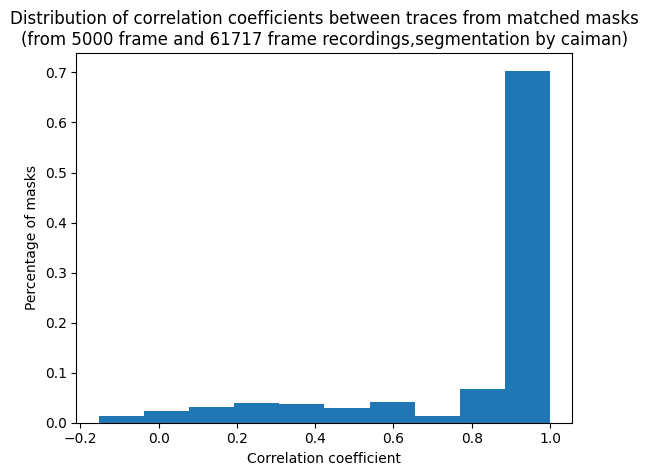

In [358]:
plt.hist(corr_coeffs, weights=np.ones(len(corr_coeffs))/len(corr_coeffs))
plt.title(f'Distribution of correlation coefficients between traces from matched masks\n(from {frame_lengths[comparison_num2]} frame and {frame_lengths[comparison_num1]} frame recordings,segmentation by {method})')
plt.xlabel('Correlation coefficient')
plt.ylabel('Percentage of masks')
#plt.savefig(f'{method}_hist')

Mask number 80
Correlation coefficient between traces: 0.947604383871298


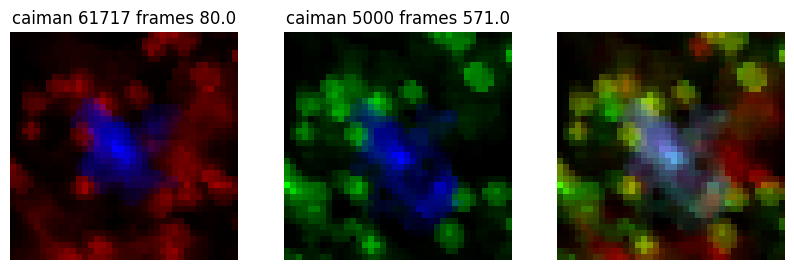

<Figure size 7680x5760 with 0 Axes>

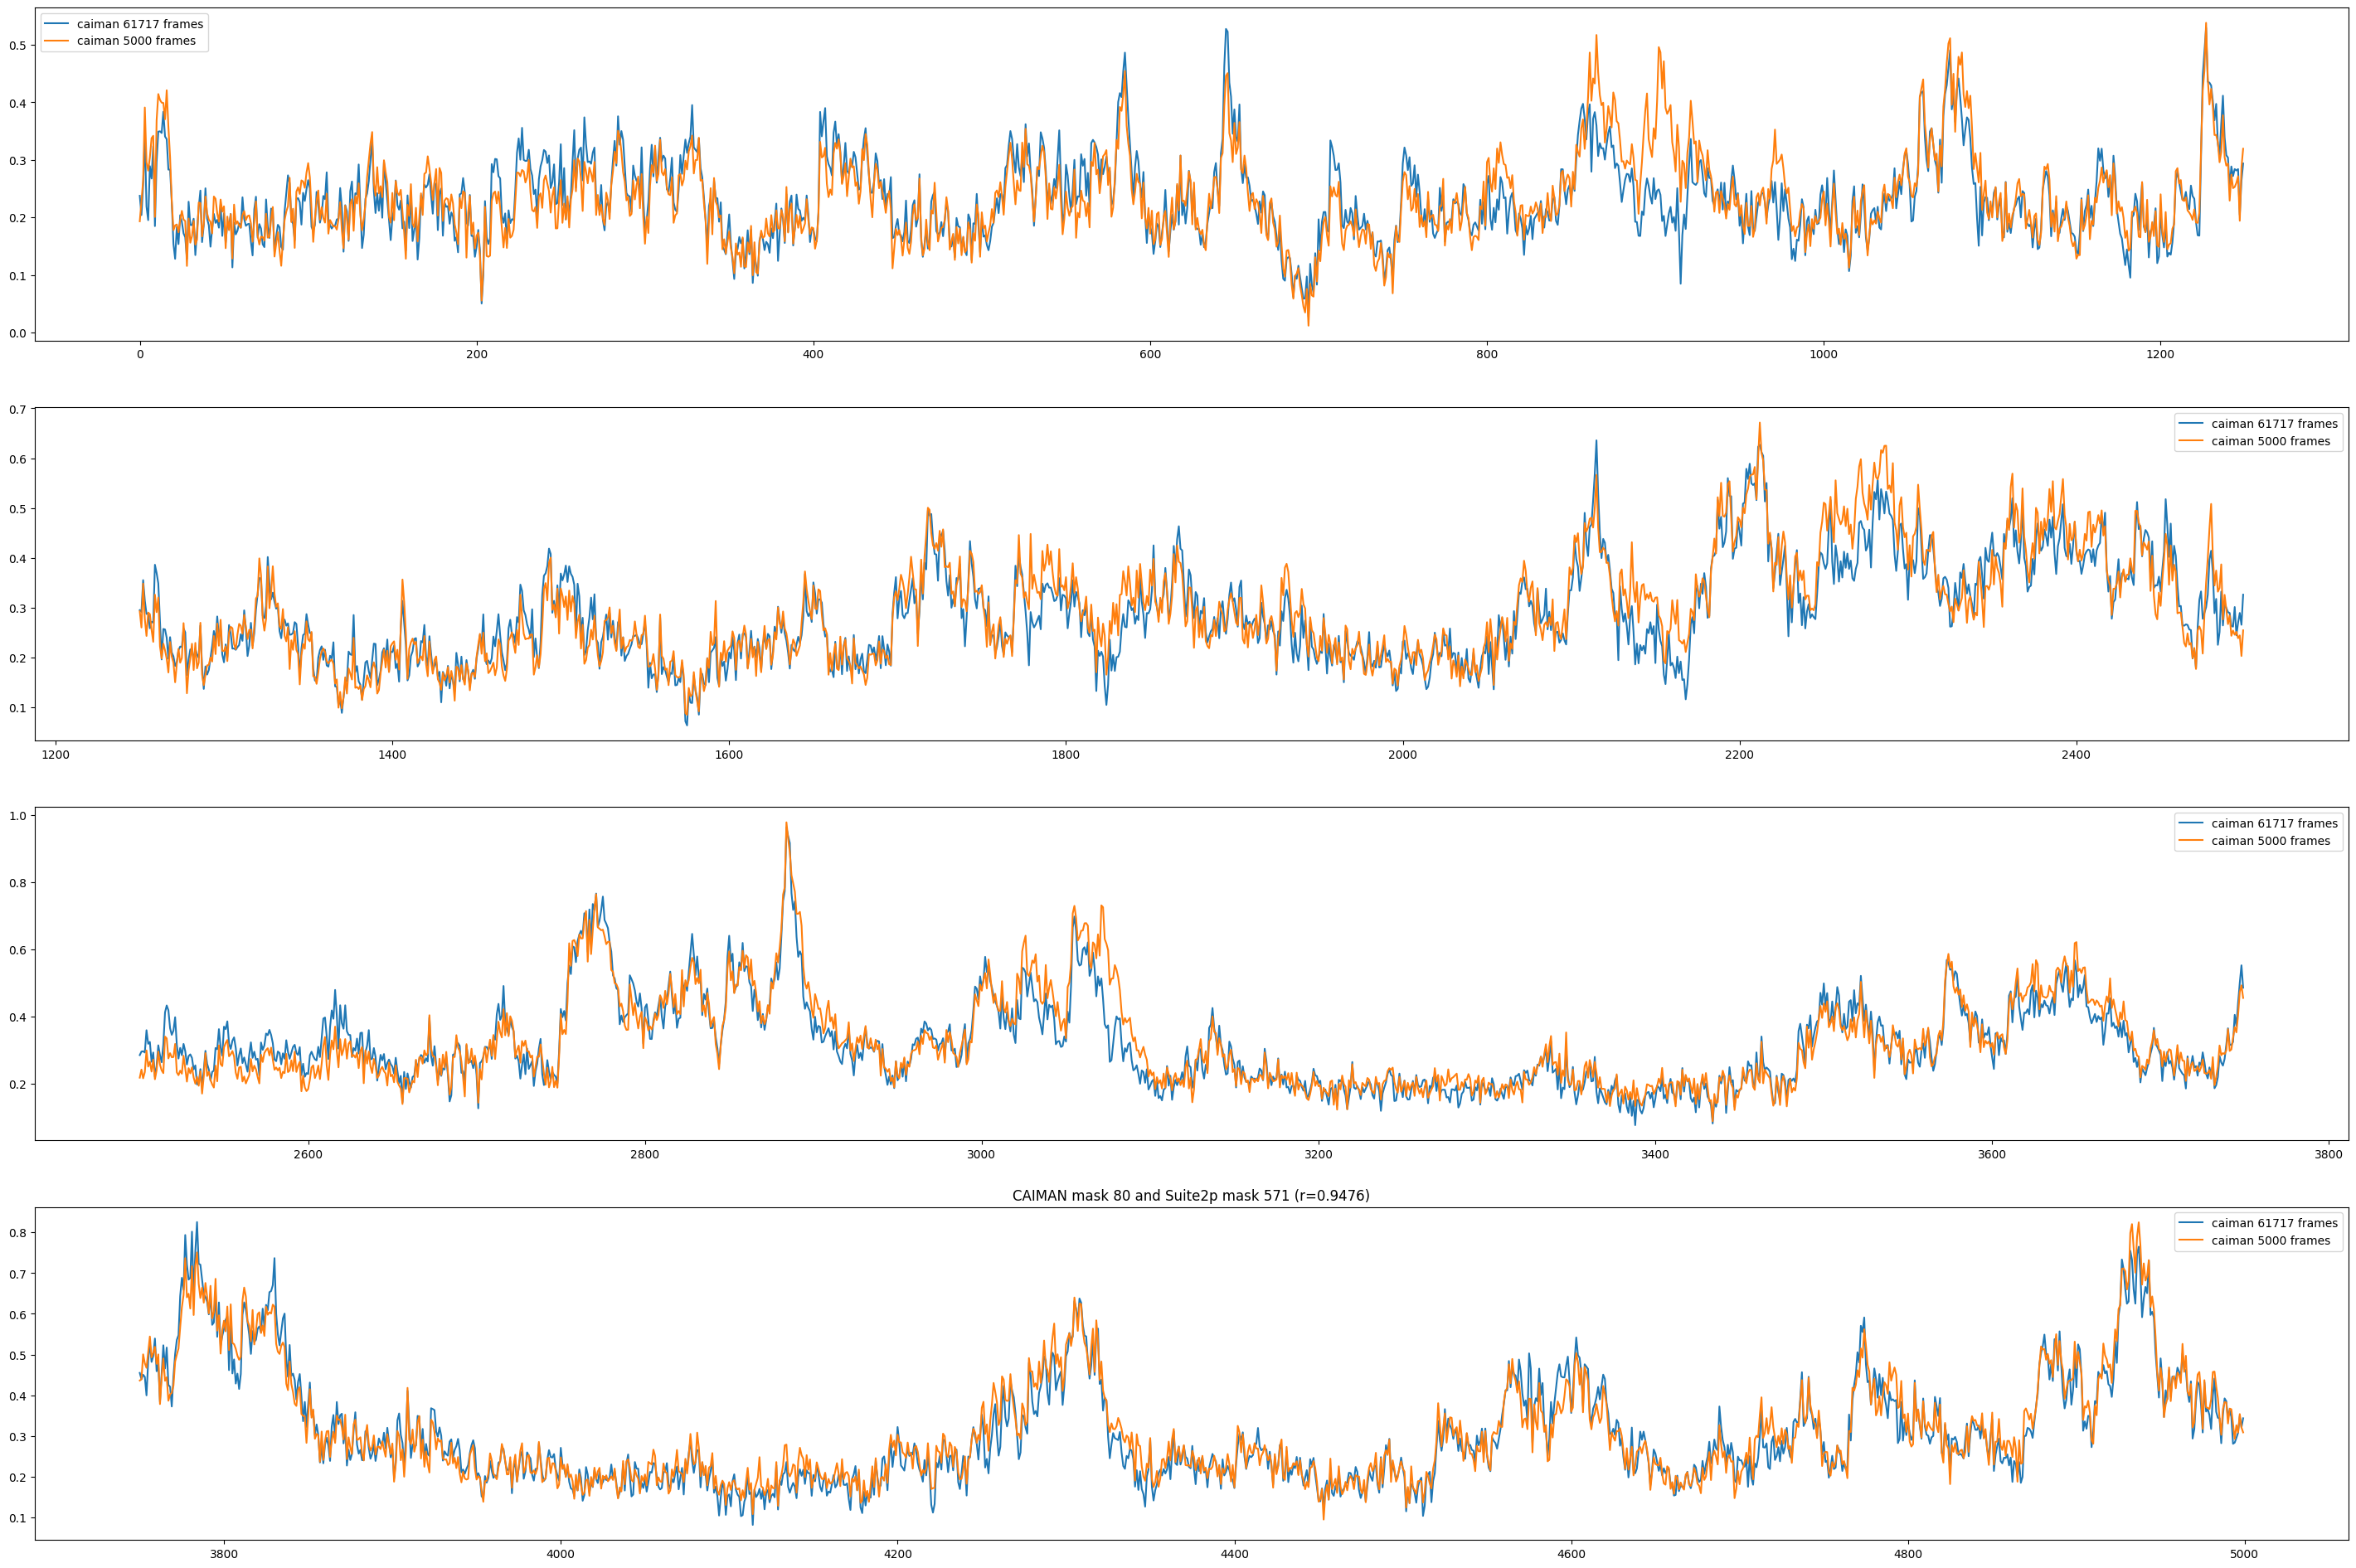

In [370]:
mask_num = np.random.randint(0,len(assignments))
#mask_num = 176
print(f'Mask number {mask_num}')
plot_comparison(masks1, masks2, assignments, mask_num, buffer=10, labels=(f'{method} {frame_lengths[comparison_num1]} frames {assignments[mask_num,0]}', f'{method} {frame_lengths[comparison_num2]} frames {assignments[mask_num,1]}'))
plot_comparison_traces(traces1, traces2, assignments, mask_num, (f'{method} {frame_lengths[comparison_num1]} frames', f'{method} {frame_lengths[comparison_num2]} frames'), smoothing_factor=0.1)

In [ ]:
# plt.plot(suite2p_traces[scan_identifier][comparison_num1][suite2p_masks[scan_identifier][comparison_num1][1],select_middle_frames(suite2p_traces[scan_identifier][comparison_num1], traces2[0].shape[-1])][126, 3500:])
plt.plot(suite2p_traces[scan_identifier][5][suite2p_masks[scan_identifier][5][1]][126][4500:6000])
plt.plot(suite2p_traces[scan_identifier][4][suite2p_masks[scan_identifier][4][1]][177][3500:])

In [ ]:
plt.plot(smooth_signal(traces1[126], 0.00001)[3500:5000])

In [ ]:
select_middle_frames(suite2p_traces[scan_identifier][comparison_num1], traces2[0].shape[-1])

In [ ]:
np.linalg.norm(normalize(suite2p_masks[scan_identifier][5][0][:,:,suite2p_masks[scan_identifier][5][1]][:,:,126]) - normalize(suite2p_masks[scan_identifier][4][0][:,:,suite2p_masks[scan_identifier][4][1]][:,:,177]))

In [ ]:
fig, axes = plt.subplots(1,
                         2, figsize=(12,12))
axes[0].imshow(suite2p_masks[scan_identifier][5][0][:,:,suite2p_masks[scan_identifier][5][1]][:,:,126])
axes[1].imshow(suite2p_masks[scan_identifier][4][0][:,:,suite2p_masks[scan_identifier][4][1]][:,:,177])

In [ ]:
buffer = 0
im = suite2p_masks[scan_identifier][5][0][:,:,suite2p_masks[scan_identifier][5][1]][:,:,126]
x_nz, y_nz = np.nonzero(im)
x_ind = max(0, x_nz.min()-buffer), min(x_nz.max()+buffer, im.shape[0])
y_ind = max(0, y_nz.min()-buffer), min(y_nz.max()+buffer, im.shape[1])

In [ ]:
normalize(im[x_ind[0]:x_ind[1]+1, y_ind[0]:y_ind[1]+1])

In [ ]:
normalize(im[x_ind[0]:x_ind[1]+1, y_ind[0]:y_ind[1]+1])-normalize(im2[x_ind[0]:x_ind[1]+1, y_ind[0]:y_ind[1]+1])

In [ ]:
scan_num = 'scan2'
frame_length = 61024
F = np.load(f'../data/suite2p/segmentation results{scan_num}/frames{frame_length}/test0/F.npy')
Fnew = np.load(f'../data/suite2p/segmentation results{scan_num}/frames{frame_length}/test0/Fneu.npy')

In [ ]:
plt.plot(F[suite2p_masks[scan_identifier][4][1],:][137,:])#-0.7*Fnew[suite2p_masks[scan_identifier][4][1],:][177,:])

In [ ]:
(F[suite2p_masks[scan_identifier][-1][1],:].mean(axis=1) < 1).sum()

In [ ]:
Fnew[suite2p_masks[scan_identifier][4][1],:].mean(axis=1)

In [ ]:
plt.imshow(suite2p_masks[scan_identifier][comparison_num2][0][x_ind[0]-10:x_ind[1]+10, y_ind[0]-10:y_ind[1]+10,:].sum(axis=-1))

In [ ]:
for i in range(masks2.shape[0]):
    if suite2p_masks[scan_identifier][comparison_num2][0][x_ind[0]:x_ind[1], y_ind[0]:y_ind[1], i].max() > 0.1:
        print(i)
#plt.imshow(suite2p_masks[scan_identifier][comparison_num2][0][x_ind[0]-10:x_ind[1]+10, y_ind[0]-10:y_ind[1]+10,suite2p_masks[scan_identifier][4][1]].sum(axis=-1))

In [ ]:
plt.imshow(suite2p_masks[scan_identifier][comparison_num2][0][x_ind[0]-10:x_ind[1]+10, y_ind[0]-10:y_ind[1]+10,7])

In [ ]:
plt.imshow(suite2p_masks[scan_identifier][comparison_num2][0][x_ind[0]-10:x_ind[1]+10, y_ind[0]-10:y_ind[1]+10,216])

In [ ]:
for min_field, max_field in zip(range(0,25,6), range(6,31,6)):
    print(min_field, max_field)